# **Introduction**

This notebook explores the use of LSTM and ARIMA models to forecast stock price fluctuations. Fluctuations is calculated by subtracting predicted prices from current values. So the first step is to develop a model capable of forecasting stock prices.


# START

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
BASE_PATH = 'drive/MyDrive/Colab Notebooks/Stock price fluctuations prediction/'

import os
print(os.listdir(BASE_PATH))

['MSN.csv', 'FPT.csv', 'VIC.csv', 'PNJ.csv', 'link.ze', 'FPT_STOCK_LSTM_model.keras', 'Predict fluctuations.ipynb']


In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras
print(sys.version)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(tf.__version__)
print(keras.__version__)

3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
1.26.4
2.1.4
1.3.2
2.17.0
3.4.1


# Dataset

In [5]:
FPT_STOCK_PATH = BASE_PATH + 'FPT.csv'
VIC_STOCK_PATH = BASE_PATH + 'VIC.csv'
MSN_STOCK_PATH = BASE_PATH + 'MSN.csv'
PNJ_STOCK_PATH = BASE_PATH + 'PNJ.csv'

In [6]:
from datetime import datetime

# Construct a dataset to predict prices in consecutive active hours (9H - 14H everyday, except 12H)
def construct_dataset(path):
  df = pd.read_csv(path)
  df = df[['Date/Time', 'Close']]
  datetimes = []
  prices = []
  past_hour = None
  past_price = None
  datetime_str = None
  price = None
  for _, trow in df.iterrows():
    datetime_str = trow.values[0]
    price = trow.values[1]
    datetime_obj = datetime.strptime(datetime_str, '%m/%d/%Y %H:%M')
    hour = datetime_obj.hour
    datetime_str = str(datetime_obj)
    if(hour < 9 or hour > 14):
      continue
    if(past_hour != hour):
      datetimes.append(datetime_str)
      prices.append(price)
      past_hour = hour
      past_price = price
  datetimes.append(datetime_str)
  prices.append(price)
  data = {
    'datetime': datetimes,
    'price': prices
  }
  df = pd.DataFrame(data)
  return df

def describe_dataset(df):
  print(df.head(), end='\n\n')
  print(df.describe(), end='\n\n')
  print(df.info())


df_FPT = construct_dataset(FPT_STOCK_PATH)
df_VIC = construct_dataset(VIC_STOCK_PATH)
df_MSN = construct_dataset(MSN_STOCK_PATH)
df_PNJ = construct_dataset(PNJ_STOCK_PATH)

In [ ]:
describe_dataset(df_FPT)

              datetime  price
0  2018-12-25 09:15:00  30.89
1  2018-12-26 10:01:00  31.15
2  2018-12-26 11:00:00  31.07
3  2018-12-26 13:00:00  30.96
4  2018-12-26 14:01:00  31.04

             price
count  2491.000000
mean     44.373332
std       6.747006
min      30.290000
25%      38.280000
50%      46.520000
75%      49.000000
max      58.100000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491 entries, 0 to 2490
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  2491 non-null   object 
 1   price     2491 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.0+ KB
None


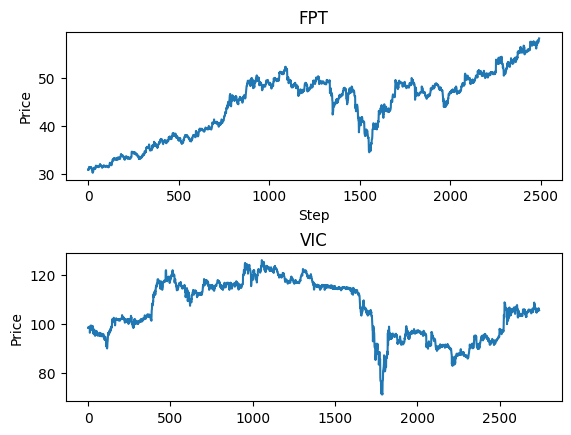

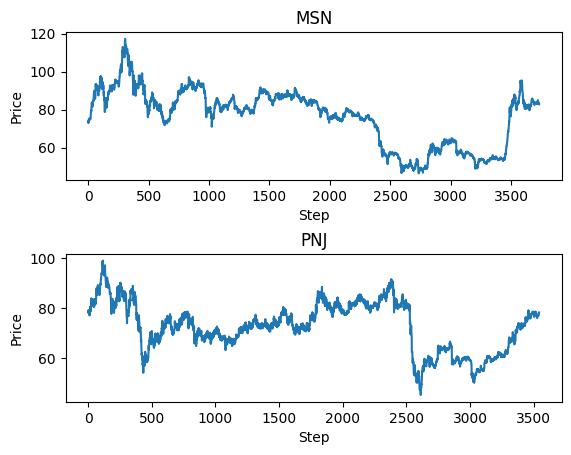

In [ ]:
plt.subplot(2, 1, 1)
plt.xlabel('Step')
plt.ylabel('Price')
plt.plot(df_FPT['price'])
plt.title('FPT')
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 1, 2)
plt.ylabel('Price')
plt.plot(df_VIC['price'])
plt.title('VIC')

plt.show()
plt.subplot(2, 1, 1)
plt.xlabel('Step')
plt.ylabel('Price')
plt.plot(df_MSN['price'])
plt.title('MSN')
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 1, 2)
plt.xlabel('Step')
plt.ylabel('Price')
plt.plot(df_PNJ['price'])
plt.title('PNJ')

plt.show()

In [7]:
test_size = 128
slice_index = [df_FPT.shape[0] - test_size, df_VIC.shape[0] - test_size, df_MSN.shape[0] - test_size, df_PNJ.shape[0] - test_size]
DATASETS = {
  'FPT_STOCK': (df_FPT['price'][:slice_index[0]].to_numpy(), df_FPT['price'][slice_index[0]:].to_numpy()),
  'VIC_STOCK': (df_VIC['price'][:slice_index[1]].to_numpy(), df_VIC['price'][slice_index[1]:].to_numpy()),
  'MSN_STOCK': (df_MSN['price'][:slice_index[2]].to_numpy(), df_MSN['price'][slice_index[2]:].to_numpy()),
  'PNJ_STOCK': (df_PNJ['price'][:slice_index[3]].to_numpy(), df_PNJ['price'][slice_index[3]:].to_numpy())
}
print(DATASETS['FPT_STOCK'][0].shape, DATASETS['FPT_STOCK'][1].shape)

(2363,) (128,)


# Training the model

## LSTM

In [8]:
CODE = 'FPT_STOCK'

In [9]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

raw_X_train, X_test = DATASETS[CODE][0].copy(), DATASETS[CODE][1].copy()
std_X_train = std_scaler.fit_transform(raw_X_train.reshape(-1, 1))

In [10]:
def construct_train_set(data, timesteps=64):
  data = data.reshape(-1, 1)
  X_train, y_train = [], []
  for i in range(timesteps, data.shape[0]):
    X_train.append(data[i-timesteps:i, :])
    y_train.append(data[i, :])
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return X_train, y_train

X_train, y_train = construct_train_set(std_X_train)
print(X_train, y_train)

[[[-2.02948077]
  [-1.98841457]
  [-2.00105033]
  ...
  [-1.8999643 ]
  [-1.88890802]
  [-1.87627227]]

 [[-1.98841457]
  [-2.00105033]
  [-2.01842449]
  ...
  [-1.88890802]
  [-1.87627227]
  [-1.86995439]]

 [[-2.00105033]
  [-2.01842449]
  [-2.00578873]
  ...
  [-1.87627227]
  [-1.86995439]
  [-1.84152395]]

 ...

 [[ 1.08365283]
  [ 1.06785814]
  [ 1.09944752]
  ...
  [ 1.58908294]
  [ 1.54169887]
  [ 1.57328825]]

 [[ 1.06785814]
  [ 1.09944752]
  [ 1.1310369 ]
  ...
  [ 1.54169887]
  [ 1.57328825]
  [ 1.55749356]]

 [[ 1.09944752]
  [ 1.1310369 ]
  [ 1.21001036]
  ...
  [ 1.57328825]
  [ 1.55749356]
  [ 1.4943148 ]]] [[-1.86995439]
 [-1.84152395]
 [-1.86521598]
 ...
 [ 1.55749356]
 [ 1.4943148 ]
 [ 1.51010949]]


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0097 - val_loss: 0.0072
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0045 - val_loss: 0.0038


MSE: 13.382023168222034


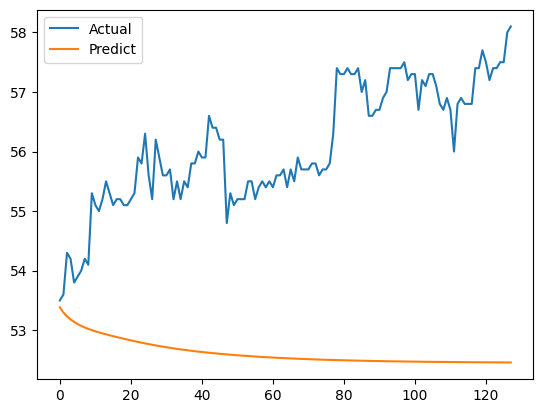

In [33]:
from sklearn.metrics import mean_squared_error

def evaluate(std_model, train_data, test_data, timesteps=64):
  train_data = train_data.reshape(-1, 1)
  test_data = test_data.reshape(-1, 1)
  instance = train_data[train_data.shape[0]-timesteps:, :]
  predictions = []
  for i in range(X_test.shape[0]):
    std_prediction = std_model.predict(instance.reshape(1, timesteps, 1), verbose=0)
    prediction = std_scaler.inverse_transform(std_prediction)
    predictions.append(prediction[0])
    instance = np.append(instance[1:], std_prediction)
  print('MSE:', end=' ')
  print(mean_squared_error(test_data, predictions))
  plt.plot(test_data, label='Actual')
  plt.plot(predictions, label='Predict')
  plt.legend()
  plt.show()
  return

evaluate(model, X_train, X_test) # X_train is standardized while X_test is not

LSTM can only reliably forecast stock prices for the next few hours, using 64 hours of historical data.

In [36]:
model.save(BASE_PATH + CODE + '_LSTM_model.keras')

## ARIMA

In [35]:
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00


In [110]:
CODE = 'MSN_STOCK'

train_data, test_data = DATASETS[CODE][0].copy(), DATASETS[CODE][1].copy()

In [111]:
# Reference for optimal hyper-parameter based on VIC
search_model = auto_arima(train_data,
                          start_p=0, start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
print(search_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8507.940, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8504.861, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8505.153, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8505.990, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8504.135, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8490.023, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8491.795, Time=1.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8499.606, Time=3.76 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=8488.068, Time=1.59 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8502.186, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=8489.839, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8497.651, Time=0.89 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 12.533 seconds
                               SARIMAX Results                                
Dep. Var

In [112]:
# FPT = (1, 2, 1)
# VIC = (0, 1, 1)
# MSN = (3, 1, 0)
# PNJ = (0, 1, 3)
model = ARIMA(train_data, order=(3, 1, 0))
model = model.fit()

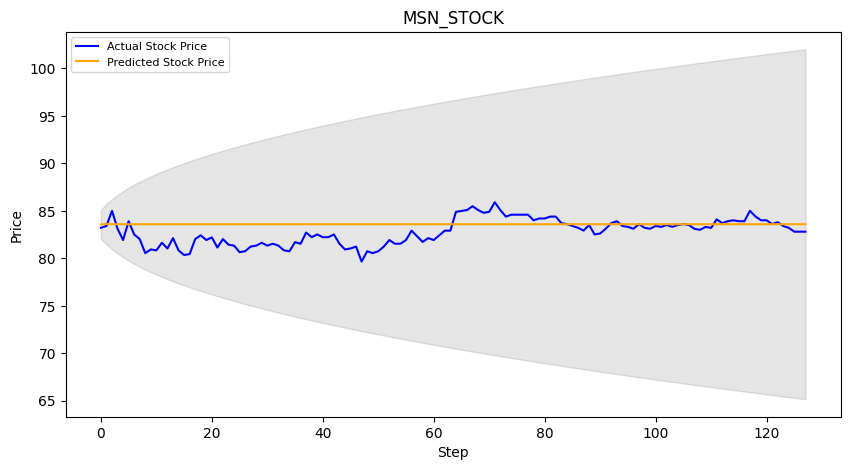

In [119]:
forecast_results = model.forecast(test_data.shape[0])
fc = forecast_results
# se = model.get_forecast(test_data.shape[0]).se_mean
conf = model.get_forecast(test_data.shape[0]).conf_int()

fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])

plt.figure(figsize=(10,5), dpi=100)
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.xlabel('Step')
plt.ylabel('Price')
plt.title(CODE)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data, fc)
print('MSE: ' + str(mse))

MSE: 2.457212529441951


In [78]:
model.save(BASE_PATH + CODE + '_ARIMA_model.pkl')

# Inference

In [81]:
keras_model = keras.saving.load_model(BASE_PATH + 'FPT_STOCK_LSTM_model.keras')

In [96]:
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
models = {
  'FPT_STOCK': ARIMAResultsWrapper.load(BASE_PATH + 'FPT_STOCK_ARIMA_model.pkl'),
  'VIC_STOCK': ARIMAResultsWrapper.load(BASE_PATH + 'VIC_STOCK_ARIMA_model.pkl'),
  'MSN_STOCK': ARIMAResultsWrapper.load(BASE_PATH + 'MSN_STOCK_ARIMA_model.pkl'),
  'PNJ_STOCK': ARIMAResultsWrapper.load(BASE_PATH + 'PNJ_STOCK_ARIMA_model.pkl')
}


In [99]:
from sklearn.metrics import mean_squared_error

codes = ['FPT_STOCK', 'VIC_STOCK', 'MSN_STOCK', 'PNJ_STOCK']

for code in codes:
  test_data = DATASETS[code][1].copy()
  predictions = models[code].forecast(test_data.shape[0])
  print(code + ' MSE: ' + str(mean_squared_error(test_data, predictions)))

FPT_STOCK MSE: 5.256416047964169
VIC_STOCK MSE: 6.937268948108053
MSN_STOCK MSE: 2.457212529441951
PNJ_STOCK MSE: 21.540941984499813


In [106]:
df_MSN.iloc[-test_size - 1, :]

,3607
datetime,2020-11-17 14:00:00
price,83.4


In [107]:
# Fluctuation in stock price from 2020-11-17 14:00 to 2020-11-18 9:00
83.4 - models['MSN_STOCK'].forecast(1)

array([-0.15937428])

The next steps should be model deployment and incremental learning.